# IoU: Intersection over Union

IoU is a confidence measurement highly used in Computer Vision.

It can be used to compute the accuracy of an object detector.

IoU (Intersection over Union) is a mesure of confidence for the relevance of a box presented as a candidate by an object detector.

This notebook has been created from this article:<br>
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

# Caltech101 - an annotated dataset

Caltech (California Institute of Technoly) supplies multiple annotated datasets for computer vison:
see ==> http://www.vision.caltech.edu/archive.html

Caltech101 is one of them and can be downloaded here: http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html

Caltech101 is a set of images of 101 different objects.<br>
Each image is related with annotations (bounding boxes in which the object is located into the image.<br>
In Caltech101, there are from 40 to 800 images per category.

In Caltech101, objects are annotated with boxes and also contours (polylines).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [95]:
# img_file = '101_ObjectCategories/dolphin/image_0005.jpg'
# img_anot = 'Annotations/dolphin/annotation_0005.mat'
img_file = '101_ObjectCategories/bonsai/image_0010.jpg'
img_anot = 'Annotations/bonsai/annotation_0010.mat'

In [96]:
# Annotations are matlab data files (.mat)
# Let's have a look on its content
annot = loadmat(img_anot)
annot

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Dec 16 11:03:55 2004',
 '__version__': '1.0',
 '__globals__': [],
 'box_coord': array([[ 21, 222,  19, 296]], dtype=uint16),
 'obj_contour': array([[254.49824561,  14.93333333,  14.57894737,  29.46315789,
          50.72631579,  58.87719298,  47.53684211,  39.74035088,
          36.19649123,  14.2245614 ,   6.07368421,  14.93333333,
          44.70175439,  74.11578947, 131.17192982, 184.68421053,
         211.97192982, 236.4245614 , 267.25614035, 275.76140351,
         263.7122807 , 245.63859649, 237.13333333, 214.45263158,
         208.42807018, 208.42807018, 237.4877193 , 258.75087719,
         258.75087719, 252.01754386, 252.01754386],
        [199.4877193 , 198.77894737, 188.14736842, 174.68070175,
         158.73333333, 154.12631579, 124.00350877, 114.78947368,
         129.31929825, 116.56140351,  91.04561404,  64.82105263,
          43.9122807 ,  27.61052632,  11.30877193,  16.6245614 ,
          26.54736842,

In [109]:
def draw_img(img_path):
    img_raw = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(7, 7))
    plt.imshow(img_rgb);
    
def draw_annotated_img(img_path, annotation_path, annot_type='box_coord', predict_box=None):
    img_raw = cv2.imread(img_file)
    if annot_type == 'box_coord':
        origin = loadmat(annotation_path)[annot_type][0]
        # if (x1,y1) is the upper left corner of the box and (x2, y2) the lower right corner of the box,
        # the 'box_coord' field is filled as [y1, y2, x1, x2]
        cv2.rectangle(img_raw, 
                      (origin[2], origin[0]),  # (x1, y1)
                      (origin[3], origin[1]),  # (x2, y2)
                      (0, 255, 0), 2
                     )
    else:
        origin = loadmat(annotation_path)['box_coord'][0]
        annot = loadmat(annotation_path)[annot_type]
        pts = np.array(list(zip((annot[0] + origin[2]).astype(int), (annot[1] + origin[0]).astype(int))))
        cv2.polylines(img_raw, [pts], True, (0, 255, 0), 2)
    if predict_box is not None:
        cv2.rectangle(img_raw, 
                      (predict_box[0], predict_box[1]),  # (x1, y1)
                      (predict_box[2], predict_box[3]),  # (x2, y2)
                      (0, 0, 255), 2
                     )
    img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(7, 7))
    plt.imshow(img_rgb);
    return [origin[2], origin[0], origin[3], origin[1]]

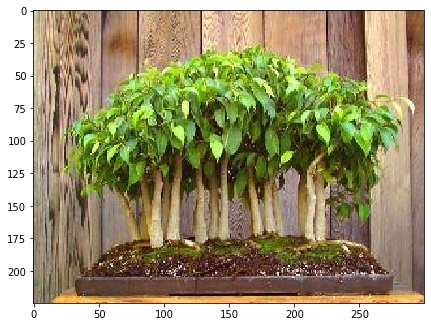

In [110]:
draw_img(img_file)

[19, 21, 296, 222]

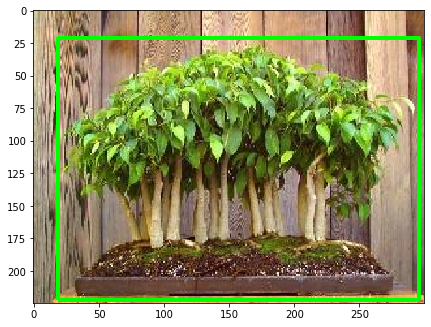

In [111]:
# Draw image with the box
draw_annotated_img(img_file, img_anot)

[19, 21, 296, 222]

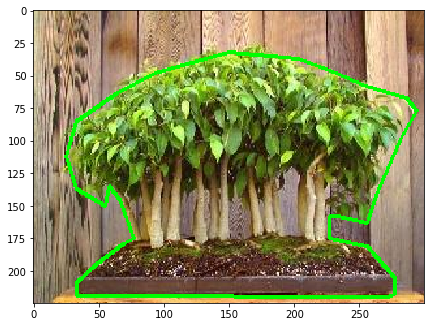

In [112]:
# Draw image with the contour
draw_annotated_img(img_file, img_anot, annot_type='obj_contour')

GT BOX (x1, y1, x2, y2) = (19, 21, 296, 222)


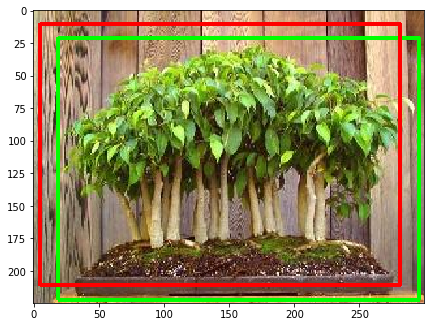

In [113]:
# We now will add a candidate bounding box (in red)
# (we have chosen it close to the ground-true box)
box_candidate = [5, 10, 281, 211]
gt_box = draw_annotated_img(img_file, img_anot, predict_box=box_candidate)
print("GT BOX (x1, y1, x2, y2) = ({}, {}, {}, {})".format(gt_box[0], gt_box[1], gt_box[2], gt_box[3]))

# Computing the IoU

To know how relevant is our candidate box, we will compute the IoU (Intersection over Union), this means:

area of the intersection of the green box and the red box / area of the union of the green box and the red box.

$ \frac{AREA~(GREEN\_BOX~~\cap~~RED\_BOX)}{AREA~(GREEN\_BOX~~\cup~~RED\_BOX)} $

In [114]:
def IoU(gt_box, predict_box):
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    predict_area = (predict_box[2] - predict_box[0]) * (predict_box[3] - predict_box[1])
    inter_box = [
        max(gt_box[0], predict_box[0]),
        max(gt_box[1], predict_box[1]),
        min(gt_box[2], predict_box[2]),
        min(gt_box[3], predict_box[3])
    ]
    inter_area = (inter_box[2] - inter_box[0]) * (inter_box[3] - inter_box[1])
    union_area = gt_area + predict_area - inter_area
    return float(inter_area) / float(union_area)

In [115]:
IoU(gt_box, box_candidate)

0.8111058608834504